In [1]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split

## Load and Preprocess Data

In [2]:
### RAW
search_dirs = ["Dataset/Equities/", "Dataset/BondsFundsIndexes/"]
stock_dict = {}

for search_dir in search_dirs:
        for filename in os.listdir(search_dir):
            if filename.endswith('.csv'):
                stock_name = filename[:-4] 
                stock_dict[stock_name] = pd.read_csv(os.path.join(search_dir, filename))

In [3]:
### Preprocess
preprocessed_stocks = {}
stock_returns = {}
minmax_scalers = {}

for stock in stock_dict:
    stock_data = stock_dict[stock]
    stock_data = stock_data.drop(columns = ['Date'])
    
    scaler = MinMaxScaler()
    preprocessed_stock = scaler.fit_transform(stock_data)
    minmax_scalers[stock] = scaler
    
    preprocessed_stock = pd.DataFrame(preprocessed_stock, columns=stock_data.columns, index=stock_data.index)
    preprocessed_stocks[stock]=preprocessed_stock
    
    

In [83]:
### Form time series
def create_time_series_data(stock_data, window_size=60):
    """
    Turn raw data into sliding window prediction.

    - stock_data: (num_days,num_features)
    - window_size: number of days to use for prediction

    
    Return
    - X: nparray um_samples, window_size, num_features)
    - y: nparray (num_samples,)
    """
    num_days = stock_data.shape[0]
    X = []
    y = []

    for i in range(num_days - window_size):
        X.append(stock_data.iloc[i:i+window_size].values)
#         print(stock_data.iloc[i:i+window_size].values.shape)
        
        ### Target Variable: Closing Price
        close_day = data['Close'].iloc[i+window_size]
        y.append(close_day)

    X = np.array(X)
    y = np.array(y)
    
    return X, y

stock_60d = {}
stock_1d = {}

for stock, data in preprocessed_stocks.items():
    stock_60d[stock], stock_1d[stock] = create_time_series_data(data)



## Define Models

In [5]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

In [6]:
class DMLPModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=15, num_hidden_layers=6, output_dim=1):
        super(DMLPModel, self).__init__()
        self.hidden_layers = nn.ModuleList()
        
        self.hidden_layers.append(nn.Linear(input_dim, hidden_dim))
        
        for _ in range(num_hidden_layers - 1):
            self.hidden_layers.append(nn.Linear(hidden_dim, hidden_dim))

        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = x.view(-1, 60 * 6)
        for layer in self.hidden_layers:
            x = self.relu(layer(x))
        x = self.output_layer(x)
        return x


class LSTMModel(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=50, num_layers=4, output_dim=1, dropout_rate=0.4, recurrent_dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=recurrent_dropout_rate)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.dropout(out[:, -1, :])  
        out = self.fc(out)
        return out
    
class CNNModel(nn.Module):
    def __init__(self, input_dim=6, output_dim=1, num_filters=2, kernel_size=2, hidden_dim=2):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=kernel_size)
        self.fc1 = nn.Linear(num_filters * (input_dim // 2 - 1), hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
 
def RandomForestModel(n_estimators=500, max_depth=20,min_samples_split=10,min_samples_leaf=10,max_features=40):
    return RandomForestRegressor(
                                    n_estimators=n_estimators,
                                    max_depth=max_depth,
                                    min_samples_split=min_samples_split,
                                    min_samples_leaf=min_samples_leaf,
                                    max_features=max_features
                                   )

def SVRModel(C=2**2, gamma=2**-3):
    return SVR(kernel='rbf', C=C, gamma=gamma)

## Train & Evaluate

In [7]:
def train_model(model, X_train, y_train, X_val, y_val, criterion, optimizer, num_epochs=100, patience=0, device='cpu', print_every=5):
    best_loss = float('inf')
    patience_counter = 0
    val_loss = 0
    
    model.to(device)
    print_every = print_every
    
    for epoch in range(num_epochs):
        model.train()

        X_train = X_train.to(device)
        y_train = y_train.to(device).view(-1,1)
        X_val = X_val.to(device)
        y_val = y_val.to(device).view(-1,1)
        

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()

        
        if epoch % print_every ==0:
            print(f"Epoch {epoch}/{num_epochs - 1}, Training Loss: {loss:.6f}")
        
        # Early stopping
            model.eval()
            with torch.no_grad():
                outputs = model(X_val)
                
                loss = criterion(outputs, y_val)
                val_loss = loss

                print(f"Validation Loss: {loss:.6f}")

#             if val_loss < best_loss:
#                 best_loss = val_loss
#                 best_model_wts = model.state_dict()
#                 patience_counter = 0
#             else:
#                 patience_counter += 1

    #         if patience_counter > patience:
    #             print("Early stopping")
    #             break
    
#     model.load_state_dict(best_model_wts)
    return model, val_loss

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train, X_test, X_val, y_train, y_val, y_test = {}, {}, {}, {}, {}, {}

# 6-1-3 split
for stock in stock_60d:
    x_train_temp, X_test[stock], y_train_temp, y_test[stock] = train_test_split(stock_60d[stock], stock_1d[stock], test_size=0.2, random_state=1)
    X_train[stock], X_val[stock], y_train[stock], y_val[stock] = train_test_split(x_train_temp, y_train_temp, test_size=0.125, random_state=1)

def to_tensor(data):
    return torch.tensor(data, dtype=torch.float32)

X_train_tensors = {stock: to_tensor(X_train[stock]) for stock in X_train}
X_val_tensors = {stock: to_tensor(X_val[stock]) for stock in X_val}
X_test_tensors = {stock: to_tensor(X_test[stock]) for stock in X_test}
y_val_tensors = {stock: to_tensor(y_val[stock]) for stock in y_val}
y_train_tensors = {stock: to_tensor(y_train[stock]) for stock in y_train}
y_test_tensors = {stock: to_tensor(y_test[stock]) for stock in y_test}

print(y_test_tensors['DEO'].shape)

torch.Size([492])


In [9]:
#DMLP
dmlp_models = {}
num_epochs = 500
learning_rate = 0.01
input_size = 6

test_losses = []
val_losses = []

for stock in X_train_tensors:
    print("model DMLP: " + stock)
#     model = LSTMModel(input_dim=input_size, hidden_dim=40)
    model = DMLPModel(input_dim=60 * input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    trained_model, val_loss = train_model(model, X_train_tensors[stock], y_train_tensors[stock], X_val_tensors[stock], y_val_tensors[stock], criterion, optimizer, num_epochs, patience=0, device=device, print_every=50)
    val_losses.append(val_loss.item())
    #Test
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(X_test_tensors[stock].to(device))
        loss = criterion(outputs, y_test_tensors[stock].to(device).view(-1,1))

        print(f"Test Loss: {loss:.6f}")
        test_losses.append(loss.item())
    dmlp_models[stock] = trained_model

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model DMLP: PEP
Epoch 0/499, Training Loss: 0.164290
Validation Loss: 0.152728
Epoch 50/499, Training Loss: 0.002291
Validation Loss: 0.002080
Epoch 100/499, Training Loss: 0.001448
Validation Loss: 0.001263
Epoch 150/499, Training Loss: 0.000929
Validation Loss: 0.000799
Epoch 200/499, Training Loss: 0.000672
Validation Loss: 0.000596
Epoch 250/499, Training Loss: 0.001110
Validation Loss: 0.002281
Epoch 300/499, Training Loss: 0.000541
Validation Loss: 0.000496
Epoch 350/499, Training Loss: 0.000474
Validation Loss: 0.000416
Epoch 400/499, Training Loss: 0.000434
Validation Loss: 0.000379
Epoch 450/499, Training Loss: 0.000400
Validation Loss: 0.000351
Test Loss: 0.001631
model DMLP: WFC
Epoch 0/499, Training Loss: 0.600262
Validation Loss: 0.428869
Epoch 50/499, Training Loss: 0.006161
Validation Loss: 0.007070
Epoch 100/499, Training Loss: 0.003548
Validation Loss: 0.003923
Epoch 150/499, Training Loss: 0.002159
Validation Loss: 0.002420
Epoch 200/499, Training Loss: 0.002036
Valid

Epoch 50/499, Training Loss: 0.001619
Validation Loss: 0.001743
Epoch 100/499, Training Loss: 0.001138
Validation Loss: 0.001443
Epoch 150/499, Training Loss: 0.000967
Validation Loss: 0.001213
Epoch 200/499, Training Loss: 0.000792
Validation Loss: 0.000968
Epoch 250/499, Training Loss: 0.000619
Validation Loss: 0.000717
Epoch 300/499, Training Loss: 0.000486
Validation Loss: 0.000513
Epoch 350/499, Training Loss: 0.000413
Validation Loss: 0.000407
Epoch 400/499, Training Loss: 0.000363
Validation Loss: 0.000352
Epoch 450/499, Training Loss: 0.000320
Validation Loss: 0.000307
Test Loss: 0.000248
model DMLP: GOOG
Epoch 0/499, Training Loss: 0.177249
Validation Loss: 0.166434
Epoch 50/499, Training Loss: 0.001801
Validation Loss: 0.002227
Epoch 100/499, Training Loss: 0.001117
Validation Loss: 0.001433
Epoch 150/499, Training Loss: 0.000911
Validation Loss: 0.001165
Epoch 200/499, Training Loss: 0.000725
Validation Loss: 0.000899
Epoch 250/499, Training Loss: 0.000561
Validation Loss: 0

Epoch 50/499, Training Loss: 0.002583
Validation Loss: 0.002602
Epoch 100/499, Training Loss: 0.001306
Validation Loss: 0.001437
Epoch 150/499, Training Loss: 0.000748
Validation Loss: 0.000805
Epoch 200/499, Training Loss: 0.000561
Validation Loss: 0.000607
Epoch 250/499, Training Loss: 0.000476
Validation Loss: 0.000522
Epoch 300/499, Training Loss: 0.000415
Validation Loss: 0.000458
Epoch 350/499, Training Loss: 0.000371
Validation Loss: 0.000411
Epoch 400/499, Training Loss: 0.000338
Validation Loss: 0.000376
Epoch 450/499, Training Loss: 0.000312
Validation Loss: 0.000347
Test Loss: 0.000244
model DMLP: GS
Epoch 0/499, Training Loss: 0.237778
Validation Loss: 0.182872
Epoch 50/499, Training Loss: 0.003543
Validation Loss: 0.003532
Epoch 100/499, Training Loss: 0.002079
Validation Loss: 0.002066
Epoch 150/499, Training Loss: 0.001085
Validation Loss: 0.001210
Epoch 200/499, Training Loss: 0.000679
Validation Loss: 0.000794
Epoch 250/499, Training Loss: 0.000539
Validation Loss: 0.0

Epoch 50/499, Training Loss: 0.004559
Validation Loss: 0.004022
Epoch 100/499, Training Loss: 0.002287
Validation Loss: 0.002295
Epoch 150/499, Training Loss: 0.001263
Validation Loss: 0.001353
Epoch 200/499, Training Loss: 0.000882
Validation Loss: 0.001047
Epoch 250/499, Training Loss: 0.000885
Validation Loss: 0.000999
Epoch 300/499, Training Loss: 0.000662
Validation Loss: 0.000915
Epoch 350/499, Training Loss: 0.000805
Validation Loss: 0.001100
Epoch 400/499, Training Loss: 0.000696
Validation Loss: 0.000900
Epoch 450/499, Training Loss: 0.000539
Validation Loss: 0.000793
Test Loss: 0.000632
model DMLP: ORCL
Epoch 0/499, Training Loss: 0.328055
Validation Loss: 0.297983
Epoch 50/499, Training Loss: 0.001958
Validation Loss: 0.001817
Epoch 100/499, Training Loss: 0.001580
Validation Loss: 0.001554
Epoch 150/499, Training Loss: 0.001321
Validation Loss: 0.001299
Epoch 200/499, Training Loss: 0.001099
Validation Loss: 0.001022
Epoch 250/499, Training Loss: 0.000758
Validation Loss: 0

Epoch 50/499, Training Loss: 0.006660
Validation Loss: 0.006825
Epoch 100/499, Training Loss: 0.001713
Validation Loss: 0.001738
Epoch 150/499, Training Loss: 0.001223
Validation Loss: 0.001310
Epoch 200/499, Training Loss: 0.000744
Validation Loss: 0.000875
Epoch 250/499, Training Loss: 0.000538
Validation Loss: 0.000693
Epoch 300/499, Training Loss: 0.003836
Validation Loss: 0.000799
Epoch 350/499, Training Loss: 0.000452
Validation Loss: 0.000614
Epoch 400/499, Training Loss: 0.000398
Validation Loss: 0.000577
Epoch 450/499, Training Loss: 0.000361
Validation Loss: 0.000549
Test Loss: 0.000614
model DMLP: EFA
Epoch 0/499, Training Loss: 0.566633
Validation Loss: 0.492016
Epoch 50/499, Training Loss: 0.011029
Validation Loss: 0.011976
Epoch 100/499, Training Loss: 0.004211
Validation Loss: 0.004679
Epoch 150/499, Training Loss: 0.002041
Validation Loss: 0.002157
Epoch 200/499, Training Loss: 0.001207
Validation Loss: 0.001258
Epoch 250/499, Training Loss: 0.000991
Validation Loss: 0.

In [11]:
#LSTM
lstm_models = {}
num_epochs = 500
learning_rate = 0.01
input_size = 6

test_losses = []
val_losses = []

for stock in X_train_tensors:
    print("model LSTM: " + stock)
    model = LSTMModel(input_dim=input_size, hidden_dim=40)
#     model = DMLPModel(input_dim=60 * input_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    trained_model, val_loss = train_model(model, X_train_tensors[stock], y_train_tensors[stock], X_val_tensors[stock], y_val_tensors[stock], criterion, optimizer, num_epochs, patience=0, device=device, print_every=20)
    val_losses.append(val_loss.item())
    #Test
    trained_model.eval()
    with torch.no_grad():
        outputs = trained_model(X_test_tensors[stock].to(device))
        loss = criterion(outputs, y_test_tensors[stock].to(device).view(-1,1))

        print(f"Test Loss: {loss:.6f}")
        test_losses.append(loss.item())
    lstm_models[stock] = trained_model

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model LSTM: PEP
Epoch 0/499, Training Loss: 0.129091
Validation Loss: 0.072615
Epoch 20/499, Training Loss: 0.017711
Validation Loss: 0.014227
Epoch 40/499, Training Loss: 0.004736
Validation Loss: 0.001028
Epoch 60/499, Training Loss: 0.003668
Validation Loss: 0.000848
Epoch 80/499, Training Loss: 0.003170
Validation Loss: 0.000551
Epoch 100/499, Training Loss: 0.003205
Validation Loss: 0.000984
Epoch 120/499, Training Loss: 0.003035
Validation Loss: 0.000534
Epoch 140/499, Training Loss: 0.002660
Validation Loss: 0.000501
Epoch 160/499, Training Loss: 0.002496
Validation Loss: 0.000508
Epoch 180/499, Training Loss: 0.002115
Validation Loss: 0.000992
Epoch 200/499, Training Loss: 0.002237
Validation Loss: 0.000459
Epoch 220/499, Training Loss: 0.002052
Validation Loss: 0.000457
Epoch 240/499, Training Loss: 0.002000
Validation Loss: 0.000486
Epoch 260/499, Training Loss: 0.002176
Validation Loss: 0.000434
Epoch 280/499, Training Loss: 0.002308
Validation Loss: 0.000498
Epoch 300/499, 

Epoch 0/499, Training Loss: 0.162567
Validation Loss: 0.067379
Epoch 20/499, Training Loss: 0.021319
Validation Loss: 0.029035
Epoch 40/499, Training Loss: 0.007839
Validation Loss: 0.002107
Epoch 60/499, Training Loss: 0.005896
Validation Loss: 0.001064
Epoch 80/499, Training Loss: 0.004040
Validation Loss: 0.001012
Epoch 100/499, Training Loss: 0.003793
Validation Loss: 0.000715
Epoch 120/499, Training Loss: 0.003453
Validation Loss: 0.000707
Epoch 140/499, Training Loss: 0.002959
Validation Loss: 0.000582
Epoch 160/499, Training Loss: 0.002696
Validation Loss: 0.000626
Epoch 180/499, Training Loss: 0.002936
Validation Loss: 0.000621
Epoch 200/499, Training Loss: 0.002579
Validation Loss: 0.000569
Epoch 220/499, Training Loss: 0.002848
Validation Loss: 0.000719
Epoch 240/499, Training Loss: 0.002330
Validation Loss: 0.000579
Epoch 260/499, Training Loss: 0.002134
Validation Loss: 0.000520
Epoch 280/499, Training Loss: 0.002170
Validation Loss: 0.000540
Epoch 300/499, Training Loss: 0

Test Loss: 0.000369
model LSTM: MRK
Epoch 0/499, Training Loss: 0.082909
Validation Loss: 0.056340
Epoch 20/499, Training Loss: 0.006051
Validation Loss: 0.001554
Epoch 40/499, Training Loss: 0.002838
Validation Loss: 0.001059
Epoch 60/499, Training Loss: 0.002300
Validation Loss: 0.000697
Epoch 80/499, Training Loss: 0.002095
Validation Loss: 0.000585
Epoch 100/499, Training Loss: 0.001896
Validation Loss: 0.000588
Epoch 120/499, Training Loss: 0.001768
Validation Loss: 0.000732
Epoch 140/499, Training Loss: 0.001979
Validation Loss: 0.000602
Epoch 160/499, Training Loss: 0.001716
Validation Loss: 0.000719
Epoch 180/499, Training Loss: 0.001704
Validation Loss: 0.000654
Epoch 200/499, Training Loss: 0.001801
Validation Loss: 0.000546
Epoch 220/499, Training Loss: 0.001551
Validation Loss: 0.000537
Epoch 240/499, Training Loss: 0.001458
Validation Loss: 0.000605
Epoch 260/499, Training Loss: 0.001481
Validation Loss: 0.000581
Epoch 280/499, Training Loss: 0.001676
Validation Loss: 0.00

Epoch 480/499, Training Loss: 0.001719
Validation Loss: 0.000455
Test Loss: 0.000418
model LSTM: V
Epoch 0/499, Training Loss: 0.173693
Validation Loss: 0.086901
Epoch 20/499, Training Loss: 0.012054
Validation Loss: 0.004731
Epoch 40/499, Training Loss: 0.005041
Validation Loss: 0.001069
Epoch 60/499, Training Loss: 0.003861
Validation Loss: 0.000774
Epoch 80/499, Training Loss: 0.003633
Validation Loss: 0.000432
Epoch 100/499, Training Loss: 0.003270
Validation Loss: 0.000406
Epoch 120/499, Training Loss: 0.002595
Validation Loss: 0.000765
Epoch 140/499, Training Loss: 0.002462
Validation Loss: 0.000376
Epoch 160/499, Training Loss: 0.002226
Validation Loss: 0.000380
Epoch 180/499, Training Loss: 0.002056
Validation Loss: 0.000369
Epoch 200/499, Training Loss: 0.002352
Validation Loss: 0.000488
Epoch 220/499, Training Loss: 0.002090
Validation Loss: 0.000370
Epoch 240/499, Training Loss: 0.002240
Validation Loss: 0.000336
Epoch 260/499, Training Loss: 0.001868
Validation Loss: 0.0005

Epoch 460/499, Training Loss: 0.001199
Validation Loss: 0.000244
Epoch 480/499, Training Loss: 0.000997
Validation Loss: 0.000339
Test Loss: 0.000299
model LSTM: ADM
Epoch 0/499, Training Loss: 0.143820
Validation Loss: 0.059375
Epoch 20/499, Training Loss: 0.047482
Validation Loss: 0.047706
Epoch 40/499, Training Loss: 0.012025
Validation Loss: 0.006847
Epoch 60/499, Training Loss: 0.005066
Validation Loss: 0.000990
Epoch 80/499, Training Loss: 0.003927
Validation Loss: 0.000929
Epoch 100/499, Training Loss: 0.003323
Validation Loss: 0.000751
Epoch 120/499, Training Loss: 0.003317
Validation Loss: 0.000753
Epoch 140/499, Training Loss: 0.003026
Validation Loss: 0.000765
Epoch 160/499, Training Loss: 0.002754
Validation Loss: 0.000696
Epoch 180/499, Training Loss: 0.002996
Validation Loss: 0.000805
Epoch 200/499, Training Loss: 0.002399
Validation Loss: 0.000611
Epoch 220/499, Training Loss: 0.002329
Validation Loss: 0.000589
Epoch 240/499, Training Loss: 0.002248
Validation Loss: 0.00

Epoch 440/499, Training Loss: 0.001125
Validation Loss: 0.000310
Epoch 460/499, Training Loss: 0.001278
Validation Loss: 0.000469
Epoch 480/499, Training Loss: 0.001018
Validation Loss: 0.000254
Test Loss: 0.000198
model LSTM: GS
Epoch 0/499, Training Loss: 0.109596
Validation Loss: 0.055886
Epoch 20/499, Training Loss: 0.012001
Validation Loss: 0.009789
Epoch 40/499, Training Loss: 0.004481
Validation Loss: 0.002304
Epoch 60/499, Training Loss: 0.002987
Validation Loss: 0.001296
Epoch 80/499, Training Loss: 0.002722
Validation Loss: 0.000766
Epoch 100/499, Training Loss: 0.002224
Validation Loss: 0.000770
Epoch 120/499, Training Loss: 0.002025
Validation Loss: 0.000768
Epoch 140/499, Training Loss: 0.001875
Validation Loss: 0.000666
Epoch 160/499, Training Loss: 0.001985
Validation Loss: 0.000653
Epoch 180/499, Training Loss: 0.001858
Validation Loss: 0.000677
Epoch 200/499, Training Loss: 0.001761
Validation Loss: 0.000586
Epoch 220/499, Training Loss: 0.001757
Validation Loss: 0.000

Epoch 420/499, Training Loss: 0.003051
Validation Loss: 0.000725
Epoch 440/499, Training Loss: 0.003057
Validation Loss: 0.000681
Epoch 460/499, Training Loss: 0.002692
Validation Loss: 0.000530
Epoch 480/499, Training Loss: 0.002801
Validation Loss: 0.000527
Test Loss: 0.000681
model LSTM: IPGP
Epoch 0/499, Training Loss: 0.121156
Validation Loss: 0.057831
Epoch 20/499, Training Loss: 0.008775
Validation Loss: 0.006442
Epoch 40/499, Training Loss: 0.004575
Validation Loss: 0.001391
Epoch 60/499, Training Loss: 0.003713
Validation Loss: 0.001194
Epoch 80/499, Training Loss: 0.003531
Validation Loss: 0.001324
Epoch 100/499, Training Loss: 0.002810
Validation Loss: 0.001126
Epoch 120/499, Training Loss: 0.002822
Validation Loss: 0.001138
Epoch 140/499, Training Loss: 0.002516
Validation Loss: 0.001037
Epoch 160/499, Training Loss: 0.002470
Validation Loss: 0.001001
Epoch 180/499, Training Loss: 0.002574
Validation Loss: 0.001213
Epoch 200/499, Training Loss: 0.002280
Validation Loss: 0.0

Epoch 400/499, Training Loss: 0.002605
Validation Loss: 0.000740
Epoch 420/499, Training Loss: 0.002628
Validation Loss: 0.000812
Epoch 440/499, Training Loss: 0.002531
Validation Loss: 0.000587
Epoch 460/499, Training Loss: 0.002543
Validation Loss: 0.000809
Epoch 480/499, Training Loss: 0.002562
Validation Loss: 0.000679
Test Loss: 0.000682
model LSTM: DEO
Epoch 0/499, Training Loss: 0.104762
Validation Loss: 0.054151
Epoch 20/499, Training Loss: 0.007559
Validation Loss: 0.003205
Epoch 40/499, Training Loss: 0.004117
Validation Loss: 0.001159
Epoch 60/499, Training Loss: 0.003341
Validation Loss: 0.001042
Epoch 80/499, Training Loss: 0.002993
Validation Loss: 0.000875
Epoch 100/499, Training Loss: 0.002626
Validation Loss: 0.001143
Epoch 120/499, Training Loss: 0.002402
Validation Loss: 0.000982
Epoch 140/499, Training Loss: 0.002266
Validation Loss: 0.000719
Epoch 160/499, Training Loss: 0.002325
Validation Loss: 0.000695
Epoch 180/499, Training Loss: 0.001915
Validation Loss: 0.00

Epoch 380/499, Training Loss: 0.001525
Validation Loss: 0.000372
Epoch 400/499, Training Loss: 0.001347
Validation Loss: 0.000464
Epoch 420/499, Training Loss: 0.001280
Validation Loss: 0.000404
Epoch 440/499, Training Loss: 0.001343
Validation Loss: 0.000354
Epoch 460/499, Training Loss: 0.001275
Validation Loss: 0.000301
Epoch 480/499, Training Loss: 0.001370
Validation Loss: 0.000425
Test Loss: 0.000316
model LSTM: XLV
Epoch 0/499, Training Loss: 0.245315
Validation Loss: 0.134227
Epoch 20/499, Training Loss: 0.010290
Validation Loss: 0.003318
Epoch 40/499, Training Loss: 0.006487
Validation Loss: 0.000910
Epoch 60/499, Training Loss: 0.005575
Validation Loss: 0.000648
Epoch 80/499, Training Loss: 0.004350
Validation Loss: 0.000620
Epoch 100/499, Training Loss: 0.003940
Validation Loss: 0.000533
Epoch 120/499, Training Loss: 0.003656
Validation Loss: 0.000513
Epoch 140/499, Training Loss: 0.003185
Validation Loss: 0.000488
Epoch 160/499, Training Loss: 0.003101
Validation Loss: 0.00

Epoch 360/499, Training Loss: 0.002104
Validation Loss: 0.000507
Epoch 380/499, Training Loss: 0.001983
Validation Loss: 0.000455
Epoch 400/499, Training Loss: 0.001903
Validation Loss: 0.000689
Epoch 420/499, Training Loss: 0.001809
Validation Loss: 0.000640
Epoch 440/499, Training Loss: 0.001686
Validation Loss: 0.000554
Epoch 460/499, Training Loss: 0.001797
Validation Loss: 0.000396
Epoch 480/499, Training Loss: 0.001778
Validation Loss: 0.000632
Test Loss: 0.000445
model LSTM: IXP
Epoch 0/499, Training Loss: 0.177579
Validation Loss: 0.067284
Epoch 20/499, Training Loss: 0.015774
Validation Loss: 0.012876
Epoch 40/499, Training Loss: 0.007899
Validation Loss: 0.003561
Epoch 60/499, Training Loss: 0.004570
Validation Loss: 0.001275
Epoch 80/499, Training Loss: 0.003491
Validation Loss: 0.000875
Epoch 100/499, Training Loss: 0.002961
Validation Loss: 0.001095
Epoch 120/499, Training Loss: 0.003156
Validation Loss: 0.000862
Epoch 140/499, Training Loss: 0.002706
Validation Loss: 0.00

Epoch 340/499, Training Loss: 0.003452
Validation Loss: 0.000835
Epoch 360/499, Training Loss: 0.003351
Validation Loss: 0.000922
Epoch 380/499, Training Loss: 0.003261
Validation Loss: 0.000685
Epoch 400/499, Training Loss: 0.003232
Validation Loss: 0.000760
Epoch 420/499, Training Loss: 0.002976
Validation Loss: 0.000515
Epoch 440/499, Training Loss: 0.002662
Validation Loss: 0.000604
Epoch 460/499, Training Loss: 0.002249
Validation Loss: 0.000578
Epoch 480/499, Training Loss: 0.002394
Validation Loss: 0.000523
Test Loss: 0.000782
model LSTM: XLI
Epoch 0/499, Training Loss: 0.337364
Validation Loss: 0.156027
Epoch 20/499, Training Loss: 0.014574
Validation Loss: 0.005100
Epoch 40/499, Training Loss: 0.006789
Validation Loss: 0.000907
Epoch 60/499, Training Loss: 0.005688
Validation Loss: 0.000584
Epoch 80/499, Training Loss: 0.005011
Validation Loss: 0.000564
Epoch 100/499, Training Loss: 0.004555
Validation Loss: 0.000537
Epoch 120/499, Training Loss: 0.004083
Validation Loss: 0.00

In [12]:
# RF
rf_models = {}
test_losses = []
val_losses = []
input_size = 6

for stock in stock_60d:
    print("model RF: " + stock)
    model_rf = RandomForestModel()
    model_rf.fit(X_train[stock].reshape(-1,60 * input_size), y_train[stock])

    y_train_pred_rf = model_rf.predict(X_train[stock].reshape(-1,60 * input_size))
    y_val_pred_rf = model_rf.predict(X_val[stock].reshape(-1,60 * input_size))
    y_test_pred_rf = model_rf.predict(X_test[stock].reshape(-1,60 * input_size))

    train_error_rf = mean_squared_error(y_train[stock], y_train_pred_rf)
    val_error_rf = mean_squared_error(y_val[stock], y_val_pred_rf)
    test_error_rf = mean_squared_error(y_test[stock], y_test_pred_rf)
    
    rf_models[stock] = model_rf
    
    val_losses.append(val_error_rf)
    test_losses.append(test_error_rf)
        
    print(f"{stock} - Train Error: {train_error_rf:.6f}, Val Error: {val_error_rf:.6f}, Test Error: {test_error_rf:.6f}")

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model RF: PEP
PEP - Train Error: 0.000143, Val Error: 0.000199, Test Error: 0.000264
model RF: WFC
WFC - Train Error: 0.000248, Val Error: 0.000439, Test Error: 0.000473
model RF: AAPL
AAPL - Train Error: 0.000085, Val Error: 0.000151, Test Error: 0.000138
model RF: PG
PG - Train Error: 0.000136, Val Error: 0.000240, Test Error: 0.000276
model RF: JCI
JCI - Train Error: 0.000154, Val Error: 0.000287, Test Error: 0.000306
model RF: LH
LH - Train Error: 0.000143, Val Error: 0.000270, Test Error: 0.000297
model RF: ULTA
ULTA - Train Error: 0.000157, Val Error: 0.000310, Test Error: 0.000327
model RF: MCD
MCD - Train Error: 0.000093, Val Error: 0.000157, Test Error: 0.000232
model RF: HCA
HCA - Train Error: 0.000111, Val Error: 0.000144, Test Error: 0.000212
model RF: NTDOY
NTDOY - Train Error: 0.000138, Val Error: 0.000271, Test Error: 0.000221
model RF: MRK
MRK - Train Error: 0.000107, Val Error: 0.000236, Test Error: 0.000179
model RF: ARE
ARE - Train Error: 0.000164, Val Error: 0.00033

In [13]:
# SVR
SVR_models = {}
test_losses = []
val_losses = []
input_size = 6

for stock in stock_60d:
    print("model RF: " + stock)
    model_svr = SVRModel()
    model_svr.fit(X_train[stock].reshape(-1,60 * input_size), y_train[stock])

    y_train_pred_svr = model_svr.predict(X_train[stock].reshape(-1,60 * input_size))
    y_val_pred_svr = model_svr.predict(X_val[stock].reshape(-1,60 * input_size))
    y_test_pred_svr = model_svr.predict(X_test[stock].reshape(-1,60 * input_size))

    train_error_svr = mean_squared_error(y_train[stock], y_train_pred_svr)
    val_error_svr = mean_squared_error(y_val[stock], y_val_pred_svr)
    test_error_svr = mean_squared_error(y_test[stock], y_test_pred_svr)
    
    SVR_models[stock] = model_svr
    
    val_losses.append(val_error_svr)
    test_losses.append(test_error_svr)
        
    print(f"{stock} - Train Error: {train_error_svr:.6f}, Val Error: {val_error_svr:.6f}, Test Error: {test_error_svr:.6f}")

print("avg val loss", np.mean(np.array(val_losses)))
print("avg test loss", np.mean(np.array(test_losses)))

model RF: PEP
PEP - Train Error: 0.002280, Val Error: 0.002169, Test Error: 0.002126
model RF: WFC
WFC - Train Error: 0.002230, Val Error: 0.002229, Test Error: 0.002480
model RF: AAPL
AAPL - Train Error: 0.003174, Val Error: 0.002930, Test Error: 0.002985
model RF: PG
PG - Train Error: 0.001898, Val Error: 0.002002, Test Error: 0.002100
model RF: JCI
JCI - Train Error: 0.002074, Val Error: 0.002251, Test Error: 0.002440
model RF: LH
LH - Train Error: 0.002376, Val Error: 0.002416, Test Error: 0.002349
model RF: ULTA
ULTA - Train Error: 0.002418, Val Error: 0.002274, Test Error: 0.002499
model RF: MCD
MCD - Train Error: 0.003146, Val Error: 0.003409, Test Error: 0.003184
model RF: HCA
HCA - Train Error: 0.002565, Val Error: 0.002467, Test Error: 0.002477
model RF: NTDOY
NTDOY - Train Error: 0.002168, Val Error: 0.002058, Test Error: 0.002087
model RF: MRK
MRK - Train Error: 0.001719, Val Error: 0.001741, Test Error: 0.001760
model RF: ARE
ARE - Train Error: 0.001777, Val Error: 0.00182

In [ ]:
# # Save Models
# import pickle


# if not os.path.exists('Prediction_Models/'):
#     os.makedirs('Prediction_Models/')

# for 
# # save
# with open('model.pkl','wb') as f:
#     pickle.dump(clf,f)

# # load
# with open('model.pkl', 'rb') as f:
#     clf2 = pickle.load(f)

# clf2.predict(X[0:1])

### Mean test error (Next-day Closing Price Prediction)
Note: Closing Price is standardized
* SVR (2.2 * 10-3)
* **RF (2.8 * 10-4)**
* LSTM (4.6 * 10-4)
* DMLP (5.3 * 10-4)

# Prediction Visulization

In [75]:
# print(stock_60d.keys())
sample_stocks = np.random.choice(list(stock_60d.keys()), 5)
print("Visulazation Sample Stocks:", sample_stocks)


Visulazation Sample Stocks: ['HCA' 'AAPL' 'META' 'XLE' 'CME']


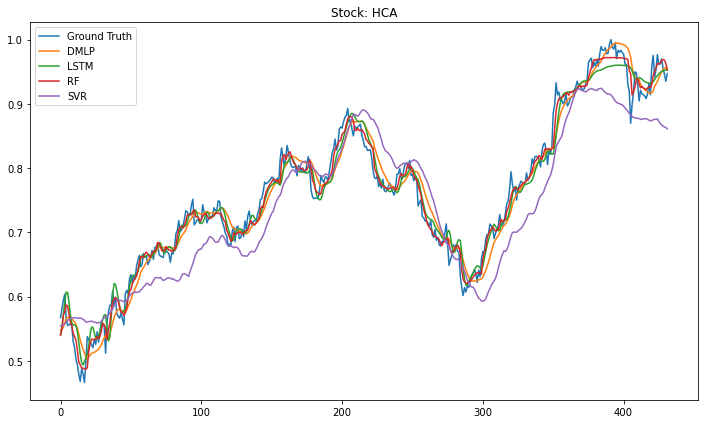

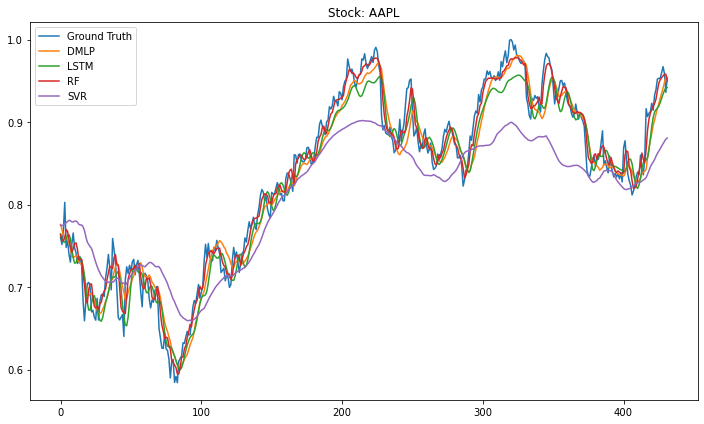

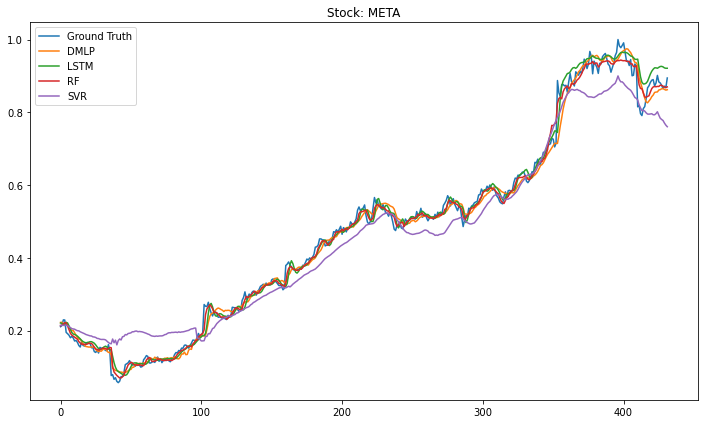

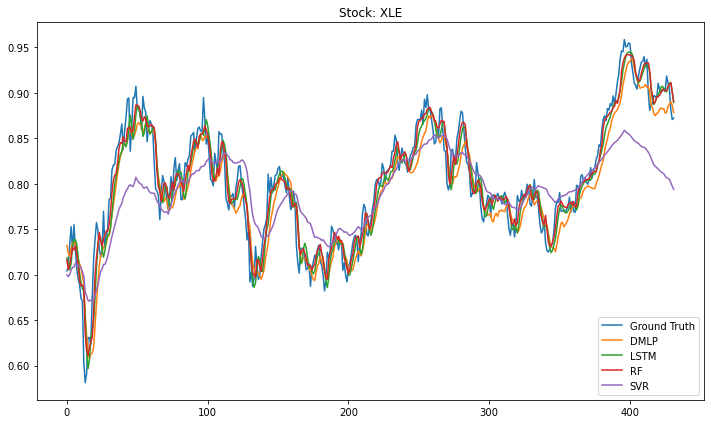

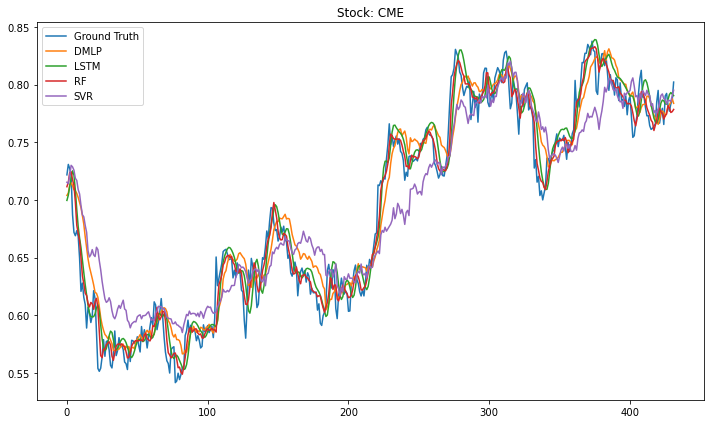

In [81]:
## Visualize each Model's Performance on Sample Stocks
for stock in sample_stocks:
    dmlp_model = dmlp_models[stock]
    lstm_model = lstm_models[stock]
    rf_model = rf_models[stock]
    svr_model = SVR_models[stock]
    
    #Plot Ground Truth
    plt.figure(figsize=(10,6))
    plt.title("Stock: " + stock)
    plt.tight_layout()
    # Ground Truth (Standardized)
    GT_closing = preprocessed_stocks[stock]['Close'].iloc[-y_test[stock].shape[0]+60:]
    plt.plot(np.arange(GT_closing.size), np.array(GT_closing), label='Ground Truth')
    
    def predict_closing_prices(model, stock_data, is_tensor = True):
        prediction = None
        time_series, _ = create_time_series_data(stock_data)

        if is_tensor:
            model.eval()
            time_series = torch.tensor(time_series, dtype=torch.float32).to(device)
            
            with torch.no_grad():
                prediction = model(time_series)
                prediction = prediction.cpu().numpy()
        else:
            prediction = model.predict(time_series.reshape(-1,60 * input_size))
                
        return prediction
    
    
    test_data = preprocessed_stocks[stock].iloc[-y_test[stock].shape[0]:]
    
    #Plot DMLP Prediction
    dmlp_predictions = predict_closing_prices(dmlp_model, test_data)
    plt.plot(np.arange(GT_closing.size), dmlp_predictions, label='DMLP')
    
    #Plot LStM Prediction
    lstm_predictions = predict_closing_prices(lstm_model, test_data)
    plt.plot(np.arange(GT_closing.size), lstm_predictions, label='LSTM')
    
    #Plot RF Prediction
    rf_predictions = predict_closing_prices(rf_model, test_data, False)
    plt.plot(np.arange(GT_closing.size), rf_predictions, label='RF')
    
    #Plot SVR Prediction
    svr_predictions = predict_closing_prices(svr_model, test_data, False)
    plt.plot(np.arange(GT_closing.size), svr_predictions, label='SVR')
    
    plt.legend()
    plt.show()

# def predict_next_day_return(model, data):
#     model.eval()
#     last_sequence = data[-seq_length:]
#     last_sequence = torch.tensor(last_sequence.values, dtype=torch.float32).unsqueeze(0).to(device)
#     with torch.no_grad():
#         prediction = model(last_sequence)
#     return prediction.item()

# predicted_returns = {}
# for stock, model in models.items():
#     predicted_returns[stock] = predict_next_day_return(model, preprocessed_data[stock])

# investment_strategy = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
# print("Investment Strategy:")
# for stock, predicted_return in investment_strategy:
#     print(f"Invest in {stock}: Predicted Return = {predicted_return:.4f}")

# investment_stocks = [stock for stock, _ in investment_strategy[:5]]  # Choose top 5 stocks to invest in

# plt.figure(figsize=(14, 7))

# for stock in investment_stocks:
#     data = stock_data[stock]
#     data['Date'] = pd.to_datetime(data['Date'])
#     data.set_index('Date', inplace=True)
#     plt.plot(data.index, data['Close'], label=f"{stock} Close Price")

# plt.title("Stock Prices of Selected Stocks to Invest In")
# plt.xlabel("Date")
# plt.ylabel("Price")
# plt.legend()
# plt.show()

# plt.figure(figsize=(10, 5))

# predicted_returns_sorted = sorted(predicted_returns.items(), key=lambda x: x[1], reverse=True)
# stocks = [stock for stock, _ in predicted_returns_sorted]
# returns = [predicted_return for _, predicted_return in predicted_returns_sorted]

# plt.bar(stocks, returns, color='green')
# plt.title("Predicted Returns for the Next Day")
# plt.xlabel("Stocks")
# plt.ylabel("Predicted Return")
# plt.xticks(rotation=45)
# plt.show()